In [ ]:
cd <your path>

Mounted at /content/drive


# Begining

## Load Modules

In [ ]:
! pip install pyspark

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 18.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=fa885e6795ba2d009ef16f920c5464b39b817cc4d9e8550b762a2fb8a6828886
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
# ! pip uninstall umap
! pip install umap-learn[plot]

     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 1.2MB 13.3MB/s 
     |████████████████████████████████| 15.8MB 401kB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 706kB 34.4MB/s 
     |████████████████████████████████| 112kB 53.0MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=215fb502cb725a8c44bc0ab524ead27fe11e743b098b4c80f17fa9354456ea03
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=e3046ff98fca3f5b9d8ea5f999399a36f569cc00e406af9d047e31d843c85924
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=4dd74fdb4c1c139f81532bbeffbde7f1bc8fcafec7

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark import StorageLevel

import sqlite3

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot

## Set Parameters

In [ ]:
PATH = './data'
FRACTION = 1.00
MODEL_PATH = 'saved_tuned_best_model_{}'.format(str(FRACTION).replace('.','_'))

N_TRACKS = 4000

MAX_MEMORY = "4g"
spark = SparkSession \
    .builder \
    .appName('quq') \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

# Load Data

## Read track encoding [parquet]

In [ ]:
track_encoding = pd.read_parquet(PATH+'/track_encoding.parquet')
track_encoding.head(2)

,track_id,track_index
0,TRLQPQJ128F42AA94F,172509
1,TRDNHAW128F429DB9A,51813


## Get track and its tag from song table & artist table [db]

### Look at all db and find tables

In [ ]:
db_list = [PATH+'/data_extension/track_metadata.db', 
           PATH+'/data_extension/mxm_dataset.db', 
           PATH+'/data_extension/artist_similarity.db', 
           PATH+'/data_extension/artist_term.db', 
           PATH+'/data_extension/lastfm_tags.db']

for db_file in db_list:
    con = sqlite3.connect(db_file)
    cursor = con.cursor()

    sql = """
            SELECT name FROM sqlite_master
            WHERE type='table'
            ORDER BY name;
            """
    cursor.execute(sql)
    print(cursor.fetchall())


[('songs',)]
[('lyrics',), ('words',)]
[('artists',), ('similarity',)]
[('artist_mbtag',), ('artist_term',), ('artists',), ('mbtags',), ('terms',)]
[('tags',), ('tid_tag',), ('tids',)]


### Read tables

In [ ]:
db_file = PATH+'/data_extension/track_metadata.db'

con = sqlite3.connect(db_file)
cursor = con.cursor()

sql = """
        SELECT * FROM songs;
        """
cursor.execute(sql)
colnames = [desc[0] for desc in cursor.description]
results = cursor.fetchall()
track_meta= pd.DataFrame(results, columns=colnames)
track_meta.head(2)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995


In [ ]:
db_file = PATH+'/data_extension/artist_term.db'

con = sqlite3.connect(db_file)
cursor = con.cursor()

sql = """
        SELECT * FROM artist_mbtag;
        """
cursor.execute(sql)
colnames = [desc[0] for desc in cursor.description]
results = cursor.fetchall()
art_mbtag = pd.DataFrame(results, columns=colnames)
art_mbtag.head(2)

,artist_id,mbtag
0,AR002UA1187B9A637D,uk
1,AR002UA1187B9A637D,rock


### Get track and itstag pairs

In [ ]:
id_tag = track_meta.drop_duplicates(subset=['track_id']) \
        .merge(pd.DataFrame(art_mbtag.groupby('artist_id').mbtag.apply(lambda x: x.sample(1))) \
               .reset_index(), on = ['artist_id']) \
        .loc[:,['track_id', 'mbtag']]

In [ ]:
track_tag = track_encoding.merge(id_tag, on = ['track_id'])
print(track_tag.mbtag.nunique())
track_tag.head(2)

987


,track_id,track_index,mbtag
0,TRLQPQJ128F42AA94F,172509,folk
1,TRDNHAW128F429DB9A,51813,heartland rock


## Load ALS model and get itemfactors

In [ ]:
model = ALSModel.load(MODEL_PATH)

In [ ]:
itemFactors = pd.DataFrame(model.itemFactors.collect(), columns = ['id', 'features']) 
print(len(itemFactors['features'][0]))
itemFactors.head(2)

100


,id,features
0,3,"[-1.5620413250871934e-05, 8.336695827892981e-0..."
1,13,"[-0.0008952911593951285, -0.000388238346204161..."


In [ ]:
track_tag_embedding = track_tag.merge(itemFactors, left_on = 'track_index',right_on = 'id', how = 'inner' )
track_tag_embedding.head(2)

,track_id,track_index,mbtag,id,features
0,TRLQPQJ128F42AA94F,172509,folk,172509,"[-0.011796296574175358, 0.013817918486893177, ..."
1,TRDNHAW128F429DB9A,51813,heartland rock,51813,"[-0.00906515121459961, 0.031062517315149307, -..."


## Sample and Plot

## Sample based on tags, data 

In [ ]:
tags_counts = track_tag_embedding.groupby('mbtag')['track_index'].count().sort_values(ascending=False)
print(tags_counts.index.tolist())

['rock and indie', 'classic pop and rock', 'folk', 'american', 'rock', 'british', 'hip hop rnb and dance hall', 'uk', 'english', 'dance and electronica', 'pop and chart', 'german', 'punk', 'electronic', 'jazz and blues', 'world', 'pop', 'finnish', 'hip hop', 'alternative rock', 'country', 'soul and reggae', 'metal', 'french', 'usa', 'progressive rock', 'production music', 'swedish', 'norwegian', 'jazz', 'canadian', 'hip-hop', 'italian', 'european', 'blues', 'américain', 'hard rock', 'easy listening soundtracks and musicals', 'progressive metal', 'heavy metal', 'classical', 'ambient', 'united states', 'indie rock', 'dutch', 'latin', '4ad', 'ska', 'thrash metal', 'death metal', 'rap', 'australian', 'indie', 'scottish', 'soul', 'soundtrack', 'black metal', 'czech', 'downtempo', 'dance', 'canada', 'hiphop', 'brazilian', 'electronica', 'blues rock', 'alternative', 'alternative metal', 'england', 'hardcore', 'art rock', 'idm', 'irish', 'turkish', 'post-rock', 'spanish', 'pop rock', 'new wave

In [ ]:
human_selected_tags = ['classical', 'folk', 'soul and reggae','hip hop', 'jazz and blues', 'electronic', 'hard rock', 'metal']
human_selected_tags_with_order = [str(i) + '_' + human_selected_tags[i] for i in range(len(human_selected_tags))]

tags_order_map = dict(zip(human_selected_tags, human_selected_tags_with_order))

In [ ]:
track_tag_embedding_selected = track_tag_embedding[track_tag_embedding.mbtag.isin(human_selected_tags)].sample(n = N_TRACKS, replace = False)
track_tag_embedding_selected['mbtag_with_order'] = track_tag_embedding_selected.mbtag.map(tags_order_map)
track_tag_embedding_selected.head(2)

,track_id,track_index,mbtag,id,features,mbtag_with_order
154180,TRKQEUD128F149190C,157123,folk,157123,"[1.3566333109338302e-05, 5.022314508096315e-05...",1_folk
69706,TRYUWVC128F4247090,368496,folk,368496,"[6.885647962917574e-06, 0.00019051661365665495...",1_folk


## Plot

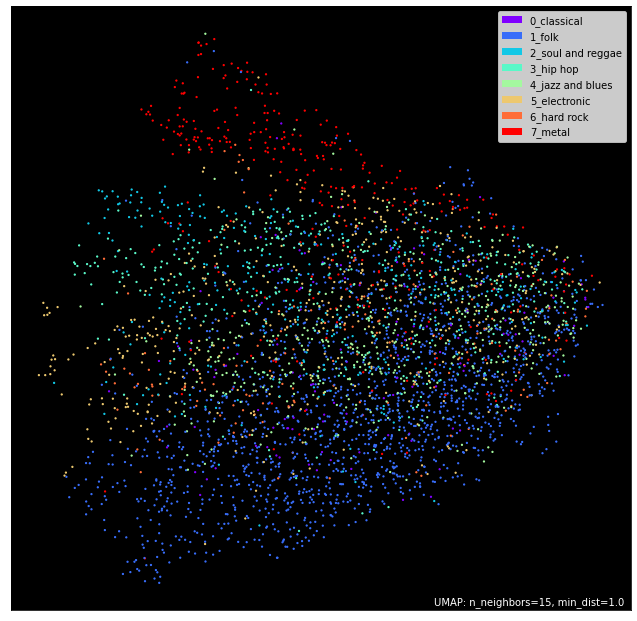

In [ ]:
minlist  = [0.001,0.01,0.1,0.2,0.5,0.8,1.0]
mapper = umap.UMAP(random_state=66, min_dist = minlist[6], metric='euclidean', n_components=2, verbose = False)\
            .fit(track_tag_embedding_selected['features'].tolist())
umap.plot.points(mapper, labels = track_tag_embedding_selected['mbtag_with_order'], theme = 'fire')